## データの読込

In [1]:
import pandas as pd
df = pd.read_csv("vgsales-12-4-2019.csv")
df.head(3)

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg


In [2]:
import os
import time
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from natsort import natsorted
from tqdm.notebook import tqdm

import optuna.integration.lightgbm as lgb
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import KFold

from sklearn.decomposition import PCA
# from tsnecuda import TSNE        # GPU用
from sklearn.manifold import TSNE # CPU用
from pandas import plotting 

import warnings
warnings.simplefilter('ignore')

In [3]:
# シード値の固定
SEED = 42

random.seed(SEED)
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(
                                                    df.dropna(subset=["Global_Sales"]).drop(["Global_Sales",  "NA_Sales", "PAL_Sales", "JP_Sales", "Other_Sales"], axis=1), 
                                                    df.dropna(subset=["Global_Sales"])["Global_Sales"],  
                                                    test_size=0.3,
                                                    shuffle=True, 
                                                    random_state=SEED
                                                    ) 

In [5]:
### 欠損値補完
X_train_ff = X_train.fillna(method='ffill')
X_test_ff = X_test.fillna(method='ffill')

#### カテゴリーエンコーディング

# ユニーク数に応じてカラムを分割する
category_unique_num = X_train_ff.select_dtypes(include="object").nunique()

few_kinds_category_columns = category_unique_num[category_unique_num < 10].index
many_kinds_category_columns = category_unique_num[category_unique_num >= 10].index


# カテゴリーのエンコーディング法則を指定する
ordinal_all_cols_mapping_ce = []

for i, column in enumerate(many_kinds_category_columns):
    ordinal_one_cols_mapping = {}
    ordinal_one_cols_mapping_breakdown = {}
    for j, category in enumerate(natsorted(X_train_ff[column].unique())):
        ordinal_one_cols_mapping_breakdown[category] = j

    ordinal_one_cols_mapping["col"] = column
    ordinal_one_cols_mapping["mapping"] = ordinal_one_cols_mapping_breakdown
    ordinal_all_cols_mapping_ce.append(ordinal_one_cols_mapping)


# エンコーディング設定
ode = ce.OrdinalEncoder(
    mapping = ordinal_all_cols_mapping_ce,
    cols = many_kinds_category_columns
)

ohe = ce.OneHotEncoder(
    use_cat_names=True,
    cols = few_kinds_category_columns
)

# 元データをコピー
X_train_ce = X_train_ff.copy()
X_test_ce = X_test_ff.copy()

# OneHotEncoder
X_train_ce = ohe.fit_transform(X_train_ce)
X_test_ce = ohe.transform(X_test_ce)

# OrdinalHotEncoder
X_train_ce = ode.fit_transform(X_train_ce)
X_test_ce = ode.transform(X_test_ce)

# 正規化
sc = StandardScaler()
X_train_ce = pd.DataFrame(
                            sc.fit_transform(X_train_ce),
                            columns=X_train_ce.columns
                            )

X_test_ce = pd.DataFrame(
                            sc.transform(X_test_ce),
                            columns=X_test_ce.columns
                            )

In [6]:
# 欠損の削除
X_train_dropna = X_train_ce.dropna(how="all", axis=1)
X_train_dropna = X_train_dropna.dropna(how="any", axis=0)

X_test_dropna = X_test_ce.dropna(how="all", axis=1)
X_test_dropna = X_test_dropna.dropna(how="any", axis=0)


# X の欠損行を削除したので、y もそれに合わせる
y_train = y_train.reset_index(drop=True)
y_train_dropna = y_train[y_train.index.isin(X_train_dropna.index)]

y_test = y_test.reset_index(drop=True)
y_test_dropna = y_test[y_test.index.isin(X_test_dropna.index)]

## 主成分分析

## PCA

In [7]:
pca = PCA(copy=True, n_components=None, whiten=False)

feature = pca.fit_transform(X_train_dropna)

  0%|          | 0/11 [00:00<?, ?it/s]

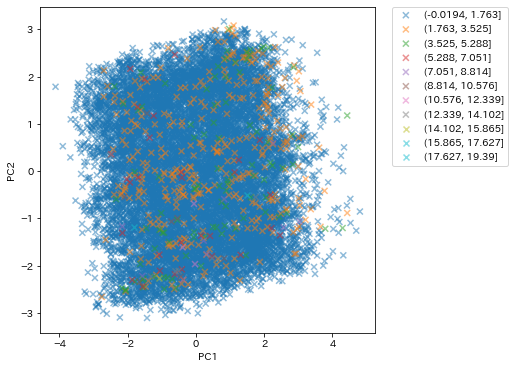

In [8]:
bins_num = 11
labels, bins = pd.cut(y_train_dropna, bins_num, retbins=True, labels=range(bins_num))
cut, bins = pd.cut(y_train_dropna, bins_num, retbins=True)

# 第一主成分と第二主成分でプロットする
plt.figure(figsize=(6, 6))

for num in tqdm(range(bins_num)):
    plt.scatter(feature[:, 0][labels==num], feature[:, 1][labels==num], alpha=0.5,
                c=[plt.get_cmap("tab10")(x) for x in labels[labels==num]],
                label=natsorted(cut.unique())[num],
                marker="x"
                )

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

In [9]:
# 寄与率
pd.DataFrame(
    pca.explained_variance_ratio_, 
    index=["PC{}".format(x + 1) for x in range(len(X_train_dropna.columns))],
    columns=["寄与率"]
    ).T

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21
寄与率,0.112901,0.100128,0.081188,0.066939,0.064491,0.057514,0.054251,0.053522,0.051536,0.049655,...,0.047001,0.045831,0.04325,0.042468,0.035735,0.033098,0.011016,0.000975,6.210149e-33,1.238370e-40


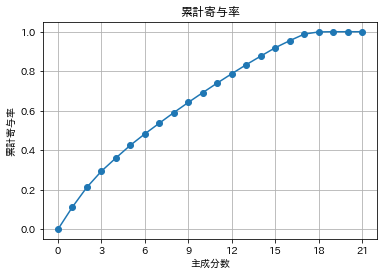

In [10]:
# 累積寄与率を図示する
import matplotlib.ticker as ticker
plt.gca().get_xaxis().set_major_locator(ticker.MaxNLocator(integer=True))
plt.plot([0] + list( np.cumsum(pca.explained_variance_ratio_)), "-o")
plt.title("累計寄与率")
plt.xlabel("主成分数")
plt.ylabel("累計寄与率")
plt.grid()
plt.show()

In [11]:
# PCA の固有ベクトル
pd.DataFrame(
    pca.components_, 
    columns=X_train_dropna.columns, 
    index=["PC{}".format(x + 1) for x in range(len(X_train_dropna.columns))]
    )

,Rank,Name,basename,Genre,ESRB_Rating_E,ESRB_Rating_T,ESRB_Rating_M,ESRB_Rating_E10,ESRB_Rating_EC,ESRB_Rating_RP,...,Publisher,Developer,Critic_Score,User_Score,Year,Last_Update,url,status,Vgchartzscore,img_url
PC1,-1.855943e-01,-1.191448e-01,-1.153045e-01,1.841858e-01,0.261640,-0.027537,-0.124559,-0.205682,-0.021388,-0.028857,...,-1.271999e-01,-1.376415e-01,-1.208588e-02,1.869730e-03,-5.480959e-01,-6.851809e-03,-5.485339e-01,-3.944305e-31,-4.145102e-03,-3.382168e-01
PC2,-5.821658e-02,6.810382e-01,6.816978e-01,2.702966e-02,-0.050240,0.130323,-0.064974,-0.030179,-0.000186,-0.015711,...,4.196680e-02,4.521275e-02,5.393780e-03,9.704683e-03,-1.279262e-01,2.578510e-02,-1.360503e-01,5.048710e-29,2.236205e-02,-4.681456e-02
PC3,-1.701314e-01,-1.107940e-01,-1.100820e-01,-1.672041e-01,-0.657502,0.558788,0.187290,0.018064,-0.004255,-0.012396,...,-3.626050e-02,-1.519226e-02,2.557075e-02,8.393322e-03,-1.201054e-01,4.453658e-02,-1.884946e-01,-2.584939e-26,8.293905e-03,-1.510378e-01
PC4,6.756341e-02,4.234833e-02,4.446574e-02,2.579994e-01,0.016842,0.182148,-0.085248,-0.178753,-0.010731,0.017570,...,-6.235008e-01,-6.108551e-01,4.980328e-02,2.337005e-02,1.307859e-01,1.746711e-02,1.562390e-01,-4.235165e-22,4.504534e-02,1.709310e-01
PC5,-3.674545e-01,5.441923e-02,5.561696e-02,7.553610e-02,-0.032736,-0.484321,0.653343,0.015772,-0.013486,-0.027162,...,-9.305901e-02,-8.427341e-02,2.005097e-01,1.297508e-01,-1.232686e-02,-1.520829e-01,-4.594014e-02,-3.176374e-22,7.342017e-02,-5.241486e-03
PC6,-8.377878e-02,1.013213e-02,1.442087e-02,-1.923430e-02,-0.197375,-0.225763,-0.250756,0.852785,-0.003388,-0.032908,...,-1.877740e-01,-1.884370e-01,-7.138463e-02,5.539461e-03,-8.552289e-02,-3.714931e-02,-9.580125e-02,1.626303e-19,6.161155e-02,-3.488078e-02
PC7,-1.507378e-01,-4.366924e-02,-4.309033e-02,1.608222e-01,0.052386,0.157536,-0.321855,0.024300,-0.053062,0.218884,...,1.369268e-01,1.284357e-01,4.867126e-01,3.553138e-01,2.682794e-02,-3.315528e-01,2.507431e-02,-6.938894e-18,4.925087e-01,7.330614e-02
PC8,3.956424e-01,4.382503e-02,3.588988e-02,-4.024123e-01,-0.126779,-0.046199,0.271750,-0.092023,0.094784,0.274228,...,-9.716362e-02,-1.765901e-01,-4.023034e-02,2.825425e-01,-9.925517e-02,-3.289890e-01,-4.309983e-02,-3.469447e-18,1.468728e-01,-6.342647e-02
PC9,8.171193e-03,-8.538343e-04,2.450691e-03,1.500062e-01,-0.047737,-0.091838,0.032356,0.045736,-0.121458,0.848366,...,2.729047e-03,4.068600e-02,-5.131438e-02,7.379276e-02,-3.413296e-02,4.471407e-01,-2.319037e-02,3.330669e-16,-1.034483e-01,-2.467861e-02
PC10,-8.408585e-02,1.019026e-02,6.522471e-03,2.988167e-02,-0.041321,-0.009089,-0.023042,-0.015207,0.475137,0.318458,...,1.328970e-03,-1.720599e-02,1.553007e-01,-7.192761e-01,-9.375964e-03,-3.465663e-01,-2.132347e-03,8.326673e-17,4.916786e-03,1.139701e-02


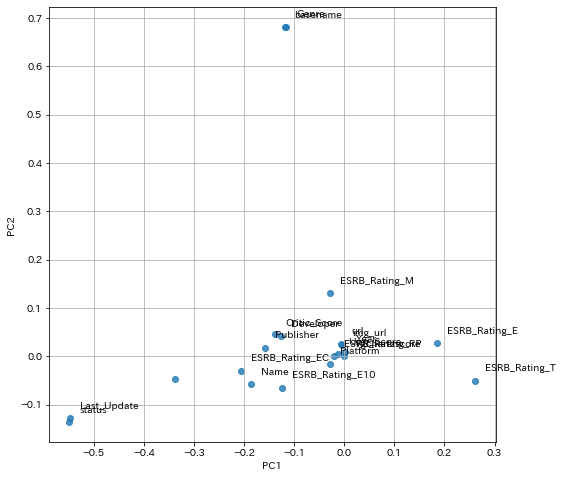

In [12]:
# 第一主成分と第二主成分における観測変数の寄与度をプロットする
plt.figure(figsize=(8, 8))
for x, y, name in zip(pca.components_[0], pca.components_[1], X_train_dropna.columns[1:]):
    plt.text(x+0.02, y+0.02, name)
plt.scatter(pca.components_[0], pca.components_[1], alpha=0.8)
plt.grid()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

## TSNE

,Global_Sales
"(-0.0194, 1.763]",12794
"(1.763, 3.525]",343
"(3.525, 5.288]",99
"(5.288, 7.051]",30
"(7.051, 8.814]",9
"(8.814, 10.576]",7
"(12.339, 14.102]",6
"(10.576, 12.339]",3
"(14.102, 15.865]",1
"(15.865, 17.627]",1


  0%|          | 0/18 [00:00<?, ?it/s]

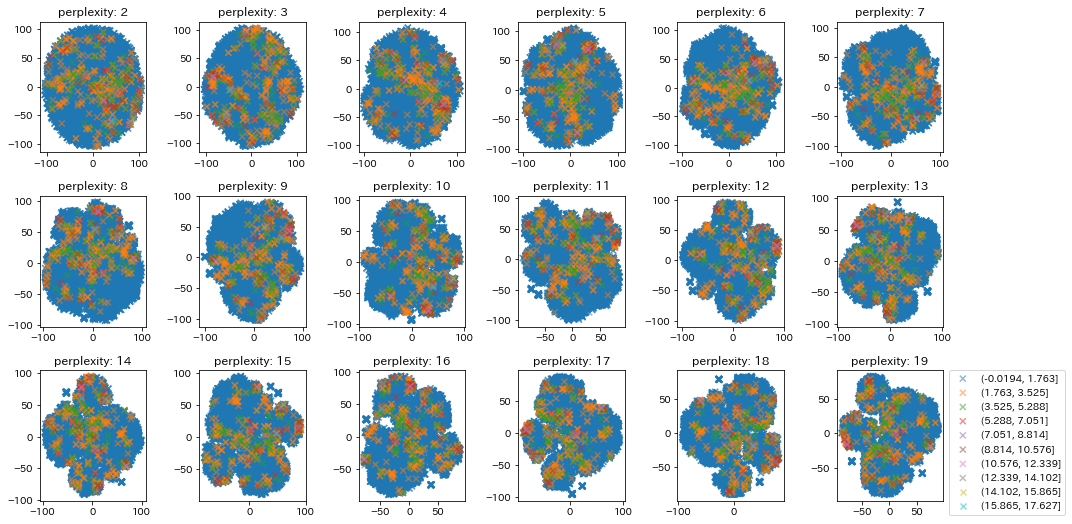

In [13]:
fig = plt.figure(figsize=(15,12))

perplexities = 20

bins_num = 11
labels, bins = pd.cut(y_train_dropna, bins_num, retbins=True, labels=range(bins_num))
cuts, bins = pd.cut(y_train_dropna, bins_num, retbins=True)

display(pd.DataFrame(cuts.value_counts()))

for i in tqdm(range(2, perplexities)):

    plt.subplot(perplexities//4, 6, i-1)

    plt.title(f"perplexity: {i}")
    model_tsne = TSNE(n_components=2, perplexity=i)
    feature = model_tsne.fit_transform(X_train_dropna)

    # 第一主成分と第二主成分でプロットする

    for num in range(bins_num-1):
        plt.scatter(feature[:, 0][labels==num], feature[:, 1][labels==num], alpha=0.5,
                    c=[plt.get_cmap("tab10")(x) for x in labels[labels==num]],
                    label=natsorted(cuts.unique())[num],
                    marker="x"
                    )

plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.tight_layout()

In [14]:
model_tsne = TSNE(n_components=2, perplexity=18)
feature = model_tsne.fit_transform(X_train_dropna)

[I 2021-12-27 16:46:59,101] A new study created in memory with name: no-name-5855cc83-7511-4190-b26c-17441780fb1c
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721050:  14%|######4                                      | 1/7 [00:00<00:01,  3.36it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.641002	Test's rmse: 0.72105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721050:  29%|############8                                | 2/7 [00:00<00:01,  3.78it/s]

Early stopping, best iteration is:
[33]	Train's rmse: 0.766052	Test's rmse: 0.801474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721050:  43%|###################2                         | 3/7 [00:00<00:01,  3.95it/s]

Early stopping, best iteration is:
[33]	Train's rmse: 0.766052	Test's rmse: 0.801474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721050:  57%|#########################7                   | 4/7 [00:01<00:00,  3.46it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.641002	Test's rmse: 0.72105
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721050:  71%|################################1            | 5/7 [00:01<00:00,  3.73it/s]

Early stopping, best iteration is:
[33]	Train's rmse: 0.766052	Test's rmse: 0.801474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721050:  86%|######################################5      | 6/7 [00:01<00:00,  3.73it/s]

Early stopping, best iteration is:
[33]	Train's rmse: 0.766052	Test's rmse: 0.801474
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721050: 100%|#############################################| 7/7 [00:01<00:00,  3.59it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.641002	Test's rmse: 0.72105


num_leaves, val_score: 0.721050:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.701452:   5%|##5                                               | 1/20 [00:01<00:19,  1.01s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.580785	Test's rmse: 0.701452
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.701452:  10%|#####                                             | 2/20 [00:01<00:11,  1.56it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.626982	Test's rmse: 0.716754
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000738 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.701149:  15%|#######5                                          | 3/20 [00:02<00:13,  1.30it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.586649	Test's rmse: 0.701149
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000436 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.701149:  20%|##########                                        | 4/20 [00:02<00:09,  1.65it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.634329	Test's rmse: 0.719313
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000243 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.701149:  25%|############5                                     | 5/20 [00:03<00:07,  1.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.643283	Test's rmse: 0.719508
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.701149:  30%|###############                                   | 6/20 [00:03<00:07,  1.77it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.598326	Test's rmse: 0.704361
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.701149:  35%|#################5                                | 7/20 [00:04<00:08,  1.61it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.603965	Test's rmse: 0.70587
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.701149:  40%|####################                              | 8/20 [00:04<00:07,  1.68it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.617315	Test's rmse: 0.711104
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000289 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.694602:  45%|######################5                           | 9/20 [00:07<00:12,  1.13s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.554091	Test's rmse: 0.694602
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.694602:  50%|########################5                        | 10/20 [00:08<00:10,  1.06s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.599838	Test's rmse: 0.708075
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.694439:  55%|##########################9                      | 11/20 [00:11<00:15,  1.74s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.551908	Test's rmse: 0.694439
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000368 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.694439:  60%|#############################4                   | 12/20 [00:14<00:16,  2.11s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.553068	Test's rmse: 0.696025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000652 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.694133:  65%|###############################8                 | 13/20 [00:17<00:16,  2.43s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.552933	Test's rmse: 0.694133
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000357 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.694133:  70%|##################################3              | 14/20 [00:19<00:14,  2.39s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.56297	Test's rmse: 0.697063
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000400 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.694133:  75%|####################################7            | 15/20 [00:22<00:11,  2.35s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.562295	Test's rmse: 0.694753
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.694133:  80%|#######################################2         | 16/20 [00:24<00:09,  2.41s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.562295	Test's rmse: 0.694753
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.694133:  85%|#########################################6       | 17/20 [00:27<00:07,  2.61s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.551547	Test's rmse: 0.696705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000331 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.694133:  90%|############################################1    | 18/20 [00:29<00:04,  2.48s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.557322	Test's rmse: 0.694928
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.694133:  95%|##############################################5  | 19/20 [00:31<00:02,  2.21s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573257	Test's rmse: 0.698608
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000394 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.694133: 100%|#################################################| 20/20 [00:33<00:00,  1.66s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.568431	Test's rmse: 0.699173


bagging, val_score: 0.694133:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.694133:  10%|#####3                                               | 1/10 [00:03<00:33,  3.68s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.593811	Test's rmse: 0.711775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000705 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.694133:  20%|##########6                                          | 2/10 [00:07<00:28,  3.52s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.553341	Test's rmse: 0.699819
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

bagging, val_score: 0.694133:  30%|###############9                                     | 3/10 [00:09<00:19,  2.83s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.615113	Test's rmse: 0.706813
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000328 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
[LightGBM] [Warning] No further s

bagging, val_score: 0.694133:  40%|#####################2                               | 4/10 [00:11<00:15,  2.54s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.605914	Test's rmse: 0.715974
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.687880:  50%|##########################5                          | 5/10 [00:13<00:12,  2.48s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000325 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.687880:  60%|###############################8                     | 6/10 [00:16<00:10,  2.60s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.570188	Test's rmse: 0.697963
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000359 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.687880:  70%|#####################################                | 7/10 [00:19<00:08,  2.78s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.549219	Test's rmse: 0.694835
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000341 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.687880:  80%|##########################################4          | 8/10 [00:22<00:05,  2.97s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.551075	Test's rmse: 0.697945
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000335 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.687880:  90%|###############################################7     | 9/10 [00:26<00:03,  3.00s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.575689	Test's rmse: 0.702682
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.687880: 100%|####################################################| 10/10 [00:29<00:00,  2.90s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.582705	Test's rmse: 0.707026


feature_fraction_stage2, val_score: 0.687880:   0%|                                              | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000382 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.687880:  17%|######3                               | 1/6 [00:03<00:15,  3.09s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000858 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.687880:  33%|############6                         | 2/6 [00:05<00:11,  2.78s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.687880:  50%|###################                   | 3/6 [00:07<00:07,  2.51s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.687880:  67%|#########################3            | 4/6 [00:10<00:04,  2.39s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.687880:  83%|###############################6      | 5/6 [00:12<00:02,  2.43s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000298 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.687880: 100%|######################################| 6/6 [00:15<00:00,  2.52s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788


regularization_factors, val_score: 0.687880:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.687880:   5%|#9                                    | 1/20 [00:02<00:50,  2.65s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.564691	Test's rmse: 0.696859
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  10%|###8                                  | 2/20 [00:05<00:46,  2.60s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.566198	Test's rmse: 0.69438
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000286 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  15%|#####7                                | 3/20 [00:07<00:44,  2.60s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.563537	Test's rmse: 0.689607
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

regularization_factors, val_score: 0.687880:  20%|#######6                              | 4/20 [00:09<00:36,  2.30s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.611986	Test's rmse: 0.707197
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  25%|#########5                            | 5/20 [00:12<00:36,  2.42s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565134	Test's rmse: 0.689152
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000154 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  30%|###########4                          | 6/20 [00:15<00:37,  2.69s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.564172	Test's rmse: 0.693427
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  35%|#############3                        | 7/20 [00:18<00:34,  2.66s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.566023	Test's rmse: 0.692379
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000329 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

regularization_factors, val_score: 0.687880:  40%|###############2                      | 8/20 [00:20<00:29,  2.44s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.59661	Test's rmse: 0.702309
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000390 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
[LightGBM] [Warning] No further sp

regularization_factors, val_score: 0.687880:  45%|#################1                    | 9/20 [00:21<00:22,  2.02s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.638271	Test's rmse: 0.708197
[

regularization_factors, val_score: 0.687880:  50%|##################5                  | 10/20 [00:24<00:24,  2.41s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565131	Test's rmse: 0.689152
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000465 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  55%|####################3                | 11/20 [00:27<00:24,  2.73s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000417 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  60%|######################2              | 12/20 [00:32<00:25,  3.18s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  65%|########################             | 13/20 [00:36<00:24,  3.52s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001215 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  70%|#########################9           | 14/20 [00:41<00:24,  4.03s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  75%|###########################7         | 15/20 [00:46<00:21,  4.28s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565131	Test's rmse: 0.689152
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000508 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  80%|#############################6       | 16/20 [00:49<00:16,  4.04s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000301 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  85%|###############################4     | 17/20 [00:52<00:10,  3.52s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  90%|#################################3   | 18/20 [00:54<00:06,  3.20s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565488	Test's rmse: 0.68788
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880:  95%|###################################1 | 19/20 [00:57<00:02,  2.94s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565131	Test's rmse: 0.689152
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687880: 100%|#####################################| 20/20 [00:59<00:00,  2.98s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565487	Test's rmse: 0.68788


min_data_in_leaf, val_score: 0.687880:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000414 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.687880:  20%|#########                                    | 1/5 [00:01<00:07,  1.81s/it]

Early stopping, best iteration is:
[19]	Train's rmse: 0.574168	Test's rmse: 0.689906
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.687880:  40%|##################                           | 2/5 [00:03<00:05,  1.94s/it]

Early stopping, best iteration is:
[30]	Train's rmse: 0.589105	Test's rmse: 0.700445
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000324 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.687880:  60%|###########################                  | 3/5 [00:06<00:04,  2.11s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.582449	Test's rmse: 0.695347
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

min_data_in_leaf, val_score: 0.687880:  80%|####################################         | 4/5 [00:07<00:01,  1.83s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.637317	Test's rmse: 0.710116
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366018
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

min_data_in_leaf, val_score: 0.687880: 100%|#############################################| 5/5 [00:08<00:00,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.675138	Test's rmse: 0.725174


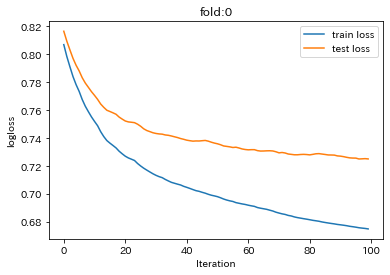

[I 2021-12-27 16:49:28,078] A new study created in memory with name: no-name-31992586-0202-4ae8-9945-ee216d1181ce
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000349 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721623:  14%|######4                                      | 1/7 [00:00<00:02,  2.56it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.635404	Test's rmse: 0.721623
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721623:  29%|############8                                | 2/7 [00:00<00:02,  2.48it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.765552	Test's rmse: 0.796627
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000393 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721623:  43%|###################2                         | 3/7 [00:01<00:01,  2.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.635404	Test's rmse: 0.721623
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721623:  57%|#########################7                   | 4/7 [00:01<00:01,  2.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.635404	Test's rmse: 0.721623
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721623:  71%|################################1            | 5/7 [00:02<00:00,  2.44it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.765552	Test's rmse: 0.796627
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000281 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721623:  86%|######################################5      | 6/7 [00:02<00:00,  2.49it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.765552	Test's rmse: 0.796627
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.721623: 100%|#############################################| 7/7 [00:02<00:00,  2.47it/s]


Early stopping, best iteration is:
[49]	Train's rmse: 0.765552	Test's rmse: 0.796627


num_leaves, val_score: 0.721623:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000302 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.709033:   5%|##5                                               | 1/20 [00:01<00:32,  1.69s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.554598	Test's rmse: 0.709033
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000304 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.709033:  10%|#####                                             | 2/20 [00:04<00:40,  2.24s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.538367	Test's rmse: 0.709376
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708702:  15%|#######5                                          | 3/20 [00:05<00:33,  1.96s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.552637	Test's rmse: 0.708702
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000339 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  20%|##########                                        | 4/20 [00:07<00:30,  1.93s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.54871	Test's rmse: 0.708364
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000346 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  25%|############5                                     | 5/20 [00:09<00:28,  1.90s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.55099	Test's rmse: 0.709472
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  30%|###############                                   | 6/20 [00:11<00:25,  1.83s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.553232	Test's rmse: 0.709492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  35%|#################5                                | 7/20 [00:13<00:25,  1.95s/it]

Early stopping, best iteration is:
[31]	Train's rmse: 0.60778	Test's rmse: 0.709996
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000241 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  40%|####################                              | 8/20 [00:13<00:17,  1.45s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.627017	Test's rmse: 0.72162
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  45%|######################5                           | 9/20 [00:14<00:13,  1.27s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.5833	Test's rmse: 0.711154
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  50%|########################5                        | 10/20 [00:16<00:14,  1.42s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.544723	Test's rmse: 0.709118
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000326 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  55%|##########################9                      | 11/20 [00:17<00:11,  1.29s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.574903	Test's rmse: 0.713281
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  60%|#############################4                   | 12/20 [00:18<00:09,  1.25s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.56884	Test's rmse: 0.710359
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  65%|###############################8                 | 13/20 [00:20<00:10,  1.55s/it]

Early stopping, best iteration is:
[35]	Train's rmse: 0.605391	Test's rmse: 0.711428
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000419 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  70%|##################################3              | 14/20 [00:22<00:09,  1.59s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.55845	Test's rmse: 0.709092
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  80%|#######################################2         | 16/20 [00:23<00:04,  1.00s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.596597	Test's rmse: 0.714374
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.763564	Test's rmse: 0.777084
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000383 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 

num_leaves, val_score: 0.708364:  85%|#########################################6       | 17/20 [00:25<00:03,  1.19s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.560186	Test's rmse: 0.709272
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  90%|############################################1    | 18/20 [00:27<00:03,  1.53s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.545364	Test's rmse: 0.709616
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000526 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364:  95%|##############################################5  | 19/20 [00:29<00:01,  1.68s/it]

Early stopping, best iteration is:
[31]	Train's rmse: 0.611515	Test's rmse: 0.710925
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000352 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.708364: 100%|#################################################| 20/20 [00:31<00:00,  1.58s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.558343	Test's rmse: 0.709385


bagging, val_score: 0.708364:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000374 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.704983:  10%|#####3                                               | 1/10 [00:02<00:21,  2.38s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542169	Test's rmse: 0.704983
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000367 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.704983:  20%|##########6                                          | 2/10 [00:04<00:19,  2.45s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.551017	Test's rmse: 0.709642
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000334 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.704983:  30%|###############9                                     | 3/10 [00:07<00:16,  2.41s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.571084	Test's rmse: 0.70803
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000387 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.704983:  40%|#####################2                               | 4/10 [00:08<00:12,  2.11s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.615913	Test's rmse: 0.717109
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.704983:  50%|##########################5                          | 5/10 [00:10<00:09,  1.97s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.549655	Test's rmse: 0.709966
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000273 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.704983:  60%|###############################8                     | 6/10 [00:12<00:07,  1.81s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.550952	Test's rmse: 0.708264
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000327 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

bagging, val_score: 0.704983:  70%|#####################################                | 7/10 [00:13<00:04,  1.67s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.610231	Test's rmse: 0.708555


[I 2021-12-27 16:50:16,020] Trial 33 finished with value: 0.7085551654225989 and parameters: {'bagging_fraction': 0.41625562123973125, 'bagging_freq': 2}. Best is trial 27 with value: 0.7049834150555777.
bagging, val_score: 0.704983:  70%|#####################################                | 7/10 [00:13<00:04,  1.67s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000285 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.704983:  80%|##########################################4          | 8/10 [00:14<00:03,  1.55s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.550426	Test's rmse: 0.707579
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.704983:  90%|###############################################7     | 9/10 [00:15<00:01,  1.43s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.586076	Test's rmse: 0.710568
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.704983: 100%|####################################################| 10/10 [00:17<00:00,  1.71s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.584349	Test's rmse: 0.706645


feature_fraction_stage2, val_score: 0.704983:   0%|                                              | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.704983:  17%|######3                               | 1/6 [00:00<00:04,  1.24it/s]

Early stopping, best iteration is:
[22]	Train's rmse: 0.765197	Test's rmse: 0.801389
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.704983:  33%|############6                         | 2/6 [00:01<00:03,  1.01it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542169	Test's rmse: 0.704983
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000272 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.704983:  50%|###################                   | 3/6 [00:03<00:03,  1.05s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542169	Test's rmse: 0.704983
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.704983:  67%|#########################3            | 4/6 [00:04<00:02,  1.08s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542169	Test's rmse: 0.704983
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.704983:  83%|###############################6      | 5/6 [00:05<00:01,  1.10s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542169	Test's rmse: 0.704983
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.704983: 100%|######################################| 6/6 [00:06<00:00,  1.07s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542169	Test's rmse: 0.704983


regularization_factors, val_score: 0.704983:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000453 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.704983:   5%|#9                                    | 1/20 [00:01<00:21,  1.15s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542169	Test's rmse: 0.704983
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.704983:  10%|###8                                  | 2/20 [00:02<00:20,  1.16s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.556981	Test's rmse: 0.705632
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.704983:  15%|#####7                                | 3/20 [00:03<00:19,  1.16s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.544383	Test's rmse: 0.705684
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.704983:  20%|#######6                              | 4/20 [00:04<00:18,  1.16s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.540546	Test's rmse: 0.70533
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.703542:  25%|#########5                            | 5/20 [00:05<00:17,  1.16s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.541535	Test's rmse: 0.703542
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.703542:  30%|###########4                          | 6/20 [00:07<00:16,  1.21s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.54217	Test's rmse: 0.704983
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.703542:  35%|#############3                        | 7/20 [00:08<00:16,  1.30s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542917	Test's rmse: 0.703707
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000279 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.703542:  40%|###############2                      | 8/20 [00:09<00:14,  1.25s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.54234	Test's rmse: 0.70686
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.703542:  40%|###############2                      | 8/20 [00:10<00:14,  1.25s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565048	Test's rmse: 0.707485


regularization_factors, val_score: 0.703542:  45%|#################1                    | 9/20 [00:10<00:13,  1.22s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.703542:  50%|##################5                  | 10/20 [00:11<00:11,  1.18s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542169	Test's rmse: 0.704983
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.703542:  55%|####################3                | 11/20 [00:13<00:10,  1.16s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.541158	Test's rmse: 0.703975
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.703542:  60%|######################2              | 12/20 [00:14<00:09,  1.15s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542141	Test's rmse: 0.70362
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.703542:  65%|########################             | 13/20 [00:15<00:08,  1.18s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542423	Test's rmse: 0.706122
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000234 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.703542:  70%|#########################9           | 14/20 [00:16<00:06,  1.16s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.540922	Test's rmse: 0.705499
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.703542:  75%|###########################7         | 15/20 [00:17<00:05,  1.11s/it]

Early stopping, best iteration is:
[42]	Train's rmse: 0.599002	Test's rmse: 0.706736
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000350 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.703542:  80%|#############################6       | 16/20 [00:18<00:04,  1.11s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542393	Test's rmse: 0.704939
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.702532:  85%|###############################4     | 17/20 [00:19<00:03,  1.12s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542268	Test's rmse: 0.702532
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.702532:  90%|#################################3   | 18/20 [00:21<00:02,  1.17s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.541311	Test's rmse: 0.703488
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

regularization_factors, val_score: 0.702532:  95%|###################################1 | 19/20 [00:21<00:01,  1.06s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.702532: 100%|#####################################| 20/20 [00:23<00:00,  1.15s/it]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542611	Test's rmse: 0.706889


min_data_in_leaf, val_score: 0.702532:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.699521:  20%|#########                                    | 1/5 [00:01<00:04,  1.14s/it]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.48489	Test's rmse: 0.699521
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

min_data_in_leaf, val_score: 0.699521:  40%|##################                           | 2/5 [00:02<00:03,  1.10s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.614008	Test's rmse: 0.71108


[I 2021-12-27 16:50:51,300] Trial 64 finished with value: 0.7110802591737945 and parameters: {'min_child_samples': 50}. Best is trial 63 with value: 0.6995211032202479.
min_data_in_leaf, val_score: 0.699521:  40%|##################                           | 2/5 [00:02<00:03,  1.10s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000277 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.693269:  60%|###########################                  | 3/5 [00:03<00:02,  1.11s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.490358	Test's rmse: 0.693269
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.693269:  80%|####################################         | 4/5 [00:04<00:01,  1.11s/it]

Early stopping, best iteration is:
[49]	Train's rmse: 0.604641	Test's rmse: 0.701827
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000270 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368599
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

min_data_in_leaf, val_score: 0.693269: 100%|#############################################| 5/5 [00:05<00:00,  1.01s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.66033	Test's rmse: 0.720547


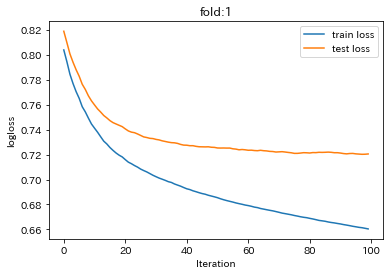

[I 2021-12-27 16:50:54,440] A new study created in memory with name: no-name-3a6ce61c-0d9c-4960-9352-611cddf62263
feature_fraction, val_score: inf:   0%|                                                          | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.778650:  14%|######4                                      | 1/7 [00:00<00:01,  4.88it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.770907	Test's rmse: 0.77865
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000449 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.778650:  29%|############8                                | 2/7 [00:00<00:01,  4.70it/s]

Early stopping, best iteration is:
[40]	Train's rmse: 0.770907	Test's rmse: 0.77865
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.637589	Test's rmse: 0.69355


feature_fraction, val_score: 0.693550:  57%|#########################7                   | 4/7 [00:00<00:00,  5.24it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.637589	Test's rmse: 0.69355
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000255 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111


feature_fraction, val_score: 0.693550:  71%|################################1            | 5/7 [00:00<00:00,  5.11it/s]

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	Train's rmse: 0.770907	Test's rmse: 0.77865


feature_fraction, val_score: 0.693550:  71%|################################1            | 5/7 [00:01<00:00,  5.11it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.637589	Test's rmse: 0.69355


feature_fraction, val_score: 0.693550: 100%|#############################################| 7/7 [00:01<00:00,  5.11it/s]


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[40]	Train's rmse: 0.770907	Test's rmse: 0.77865


num_leaves, val_score: 0.693550:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000309 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.679034:  10%|#####                                             | 2/20 [00:00<00:07,  2.49it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.609284	Test's rmse: 0.679034
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.656454	Test's rmse: 0.704555
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000208 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.679034:  15%|#######5                                          | 3/20 [00:01<00:09,  1.78it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.548415	Test's rmse: 0.683582
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  20%|##########                                        | 4/20 [00:02<00:09,  1.61it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.613286	Test's rmse: 0.678607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  25%|############5                                     | 5/20 [00:02<00:08,  1.87it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.623123	Test's rmse: 0.687045
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  30%|###############                                   | 6/20 [00:03<00:07,  1.83it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.553576	Test's rmse: 0.686638
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  35%|#################5                                | 7/20 [00:03<00:05,  2.32it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.631136	Test's rmse: 0.691482
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  45%|######################5                           | 9/20 [00:03<00:03,  3.19it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.579844	Test's rmse: 0.689353
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.676433	Test's rmse: 0.713022
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 r

num_leaves, val_score: 0.678607:  50%|########################5                        | 10/20 [00:04<00:03,  2.94it/s]

Early stopping, best iteration is:
[32]	Train's rmse: 0.616048	Test's rmse: 0.680515
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  55%|##########################9                      | 11/20 [00:04<00:03,  2.37it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.598666	Test's rmse: 0.679345
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  60%|#############################4                   | 12/20 [00:05<00:03,  2.21it/s]

Early stopping, best iteration is:
[28]	Train's rmse: 0.617033	Test's rmse: 0.679672
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000291 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  65%|###############################8                 | 13/20 [00:05<00:03,  2.20it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.616912	Test's rmse: 0.679854
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  70%|##################################3              | 14/20 [00:06<00:02,  2.21it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.618159	Test's rmse: 0.681423
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000290 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  75%|####################################7            | 15/20 [00:06<00:02,  2.26it/s]

Early stopping, best iteration is:
[26]	Train's rmse: 0.624619	Test's rmse: 0.680524
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000332 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  80%|#######################################2         | 16/20 [00:07<00:01,  2.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.578341	Test's rmse: 0.685438
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  85%|#########################################6       | 17/20 [00:07<00:01,  2.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.532801	Test's rmse: 0.684442
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  90%|############################################1    | 18/20 [00:08<00:00,  2.06it/s]

Early stopping, best iteration is:
[44]	Train's rmse: 0.59826	Test's rmse: 0.681045
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607:  95%|##############################################5  | 19/20 [00:08<00:00,  1.95it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.5919	Test's rmse: 0.680326
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.678607: 100%|#################################################| 20/20 [00:09<00:00,  2.15it/s]


Early stopping, best iteration is:
[27]	Train's rmse: 0.623482	Test's rmse: 0.680653


bagging, val_score: 0.678607:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000268 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

bagging, val_score: 0.678607:  10%|#####3                                               | 1/10 [00:00<00:05,  1.72it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

bagging, val_score: 0.678607:  20%|##########6                                          | 2/10 [00:01<00:04,  1.76it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

bagging, val_score: 0.678607:  30%|###############9                                     | 3/10 [00:01<00:04,  1.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.555479	Test's rmse: 0.686377
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.678607:  40%|#####################2                               | 4/10 [00:02<00:04,  1.42it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.543758	Test's rmse: 0.687446
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.678607:  50%|##########################5                          | 5/10 [00:03<00:03,  1.42it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.533351	Test's rmse: 0.685872
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.678607:  60%|###############################8                     | 6/10 [00:04<00:02,  1.39it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.535455	Test's rmse: 0.685387
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

bagging, val_score: 0.678607:  60%|###############################8                     | 6/10 [00:04<00:02,  1.39it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

bagging, val_score: 0.678607:  70%|#####################################                | 7/10 [00:04<00:02,  1.42it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

bagging, val_score: 0.678607:  80%|##########################################4          | 8/10 [00:05<00:01,  1.31it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000257 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.678607:  90%|###############################################7     | 9/10 [00:06<00:00,  1.31it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.562033	Test's rmse: 0.686434
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


bagging, val_score: 0.678607: 100%|####################################################| 10/10 [00:07<00:00,  1.39it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.575676	Test's rmse: 0.691619


feature_fraction_stage2, val_score: 0.678607:   0%|                                              | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.678607:  17%|######3                               | 1/6 [00:00<00:03,  1.66it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.613286	Test's rmse: 0.678607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.678607:  33%|############6                         | 2/6 [00:01<00:02,  1.70it/s]

Early stopping, best iteration is:
[22]	Train's rmse: 0.768703	Test's rmse: 0.781914
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.678607:  50%|###################                   | 3/6 [00:01<00:01,  1.60it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.613286	Test's rmse: 0.678607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000245 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.678607:  67%|#########################3            | 4/6 [00:02<00:01,  1.52it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.613286	Test's rmse: 0.678607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000282 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.678607:  83%|###############################6      | 5/6 [00:03<00:00,  1.52it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.613286	Test's rmse: 0.678607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000275 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.678607: 100%|######################################| 6/6 [00:03<00:00,  1.55it/s]


Early stopping, best iteration is:
[30]	Train's rmse: 0.613286	Test's rmse: 0.678607


regularization_factors, val_score: 0.678607:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.678607:   5%|#9                                    | 1/20 [00:00<00:13,  1.46it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.613286	Test's rmse: 0.678607
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.678607:  10%|###8                                  | 2/20 [00:01<00:12,  1.42it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.61158	Test's rmse: 0.678636
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.678210:  15%|#####7                                | 3/20 [00:02<00:11,  1.46it/s]

Early stopping, best iteration is:
[28]	Train's rmse: 0.617801	Test's rmse: 0.67821
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000259 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.678210:  20%|#######6                              | 4/20 [00:02<00:11,  1.44it/s]

Early stopping, best iteration is:
[34]	Train's rmse: 0.617541	Test's rmse: 0.68092
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000235 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.678210:  25%|#########5                            | 5/20 [00:03<00:10,  1.44it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.613286	Test's rmse: 0.678607
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.678210:  30%|###########4                          | 6/20 [00:04<00:09,  1.44it/s]

Early stopping, best iteration is:
[29]	Train's rmse: 0.616582	Test's rmse: 0.678594
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.678210:  35%|#############3                        | 7/20 [00:04<00:09,  1.43it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.613521	Test's rmse: 0.679266
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.678210:  40%|###############2                      | 8/20 [00:05<00:08,  1.42it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.613286	Test's rmse: 0.678607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000267 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.678210:  45%|#################1                    | 9/20 [00:06<00:07,  1.43it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.611295	Test's rmse: 0.678934
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000271 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.678210:  50%|##################5                  | 10/20 [00:06<00:06,  1.47it/s]

Early stopping, best iteration is:
[28]	Train's rmse: 0.618854	Test's rmse: 0.680375
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000239 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

regularization_factors, val_score: 0.678210:  55%|####################3                | 11/20 [00:07<00:05,  1.59it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.678210:  60%|######################2              | 12/20 [00:08<00:05,  1.56it/s]

Early stopping, best iteration is:
[27]	Train's rmse: 0.622144	Test's rmse: 0.67968
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000265 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.677655:  65%|########################             | 13/20 [00:08<00:04,  1.52it/s]

Early stopping, best iteration is:
[33]	Train's rmse: 0.60709	Test's rmse: 0.677655
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.677655:  70%|#########################9           | 14/20 [00:09<00:04,  1.47it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.610583	Test's rmse: 0.677939
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.677655:  75%|###########################7         | 15/20 [00:10<00:03,  1.43it/s]

Early stopping, best iteration is:
[33]	Train's rmse: 0.607091	Test's rmse: 0.677655
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000258 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.677655:  80%|#############################6       | 16/20 [00:10<00:02,  1.45it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.613286	Test's rmse: 0.678607
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.677655:  85%|###############################4     | 17/20 [00:11<00:02,  1.49it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.611225	Test's rmse: 0.679964
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.677655:  90%|#################################3   | 18/20 [00:12<00:01,  1.57it/s]

Early stopping, best iteration is:
[31]	Train's rmse: 0.610584	Test's rmse: 0.677939
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.677655:  95%|###################################1 | 19/20 [00:12<00:00,  1.63it/s]

Early stopping, best iteration is:
[30]	Train's rmse: 0.613286	Test's rmse: 0.678607
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.677655: 100%|#####################################| 20/20 [00:13<00:00,  1.51it/s]


Early stopping, best iteration is:
[35]	Train's rmse: 0.603213	Test's rmse: 0.680254


min_data_in_leaf, val_score: 0.677655:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.677655:  20%|#########                                    | 1/5 [00:00<00:01,  2.04it/s]

Early stopping, best iteration is:
[19]	Train's rmse: 0.543517	Test's rmse: 0.686492
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.677655:  40%|##################                           | 2/5 [00:01<00:01,  1.66it/s]

Early stopping, best iteration is:
[28]	Train's rmse: 0.566829	Test's rmse: 0.680522
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

min_data_in_leaf, val_score: 0.677655:  60%|###########################                  | 3/5 [00:01<00:01,  1.99it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.665592	Test's rmse: 0.701169
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.677655:  80%|####################################         | 4/5 [00:02<00:00,  1.45it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.554672	Test's rmse: 0.68679
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.368111
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

min_data_in_leaf, val_score: 0.677655:  80%|####################################         | 4/5 [00:03<00:00,  1.45it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.677655: 100%|#############################################| 5/5 [00:03<00:00,  1.57it/s]


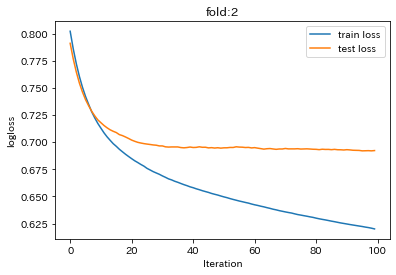

[I 2021-12-27 16:51:32,871] A new study created in memory with name: no-name-03075d48-cfde-4ba5-b359-b0bfd2833bfe
feature_fraction, val_score: 0.804735:  14%|######4                                      | 1/7 [00:00<00:01,  5.75it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.760734	Test's rmse: 0.804735
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2


feature_fraction, val_score: 0.804735:  29%|############8                                | 2/7 [00:00<00:00,  6.00it/s]

[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.760734	Test's rmse: 0.804735
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.745156:  57%|#########################7                   | 4/7 [00:00<00:00,  5.85it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.760734	Test's rmse: 0.804735
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000225 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.633338	Test's rmse: 0.745156


feature_fraction, val_score: 0.745156:  71%|################################1            | 5/7 [00:00<00:00,  5.88it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.633338	Test's rmse: 0.745156
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885


feature_fraction, val_score: 0.745156:  86%|######################################5      | 6/7 [00:01<00:00,  5.74it/s]

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.633338	Test's rmse: 0.745156
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.745156: 100%|#############################################| 7/7 [00:01<00:00,  5.74it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.760734	Test's rmse: 0.804735


num_leaves, val_score: 0.745156:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001314 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.724167:   5%|##5                                               | 1/20 [00:00<00:13,  1.40it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.546841	Test's rmse: 0.724167
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.719189:  10%|#####                                             | 2/20 [00:01<00:13,  1.35it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.54168	Test's rmse: 0.719189
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.719189:  15%|#######5                                          | 3/20 [00:02<00:11,  1.46it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.550882	Test's rmse: 0.72183
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.719189:  20%|##########                                        | 4/20 [00:02<00:12,  1.31it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.537334	Test's rmse: 0.724087
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.719189:  25%|############5                                     | 5/20 [00:03<00:11,  1.29it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.540386	Test's rmse: 0.722585
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.719189:  35%|#################5                                | 7/20 [00:04<00:05,  2.23it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.593179	Test's rmse: 0.726502
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.679002	Test's rmse: 0.761688
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 r

num_leaves, val_score: 0.719189:  40%|####################                              | 8/20 [00:04<00:06,  1.97it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.550458	Test's rmse: 0.722443
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000180 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.719189:  50%|########################5                        | 10/20 [00:05<00:04,  2.15it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.577939	Test's rmse: 0.727013
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.755752	Test's rmse: 0.79436
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 ro

num_leaves, val_score: 0.719189:  55%|##########################9                      | 11/20 [00:05<00:03,  2.59it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.561889	Test's rmse: 0.724421
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.719189:  60%|#############################4                   | 12/20 [00:06<00:03,  2.33it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.55662	Test's rmse: 0.722739
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.719189:  65%|###############################8                 | 13/20 [00:06<00:03,  2.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.544624	Test's rmse: 0.720597
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.718702:  70%|##################################3              | 14/20 [00:07<00:03,  1.97it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542639	Test's rmse: 0.718702
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.718702:  75%|####################################7            | 15/20 [00:08<00:02,  1.78it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.538053	Test's rmse: 0.722756
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.718702:  80%|#######################################2         | 16/20 [00:08<00:02,  1.74it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542639	Test's rmse: 0.718702
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.718702:  85%|#########################################6       | 17/20 [00:09<00:01,  1.90it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.563024	Test's rmse: 0.72598
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.718702:  90%|############################################1    | 18/20 [00:09<00:00,  2.22it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.583191	Test's rmse: 0.729936
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.718702:  95%|##############################################5  | 19/20 [00:10<00:00,  1.99it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.54282	Test's rmse: 0.723547
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.718702: 100%|#################################################| 20/20 [00:10<00:00,  1.94it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.622739	Test's rmse: 0.741156


bagging, val_score: 0.718702:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000166 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.718702:  10%|#####3                                               | 1/10 [00:00<00:04,  2.02it/s]

Early stopping, best iteration is:
[38]	Train's rmse: 0.627146	Test's rmse: 0.721111
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.718702:  20%|##########6                                          | 2/10 [00:01<00:04,  1.66it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.541613	Test's rmse: 0.721041
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000170 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.718702:  30%|###############9                                     | 3/10 [00:01<00:04,  1.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542726	Test's rmse: 0.72072
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.718702:  40%|#####################2                               | 4/10 [00:02<00:03,  1.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.556952	Test's rmse: 0.734651
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.718702:  50%|##########################5                          | 5/10 [00:03<00:03,  1.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.554996	Test's rmse: 0.72521
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, 

bagging, val_score: 0.718702:  60%|###############################8                     | 6/10 [00:03<00:02,  1.59it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.599699	Test's rmse: 0.728398
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of 

bagging, val_score: 0.718702:  70%|#####################################                | 7/10 [00:04<00:01,  1.58it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.547476	Test's rmse: 0.723455
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.718702:  80%|##########################################4          | 8/10 [00:05<00:01,  1.45it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.592431	Test's rmse: 0.724956
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

bagging, val_score: 0.718702:  90%|###############################################7     | 9/10 [00:05<00:00,  1.52it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.604275	Test's rmse: 0.736319
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't impro

bagging, val_score: 0.718702: 100%|####################################################| 10/10 [00:06<00:00,  1.55it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.541076	Test's rmse: 0.718756


feature_fraction_stage2, val_score: 0.718702:   0%|                                              | 0/3 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.718702:  33%|############6                         | 1/3 [00:00<00:01,  1.64it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542639	Test's rmse: 0.718702
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.718702:  67%|#########################3            | 2/3 [00:01<00:00,  1.61it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542639	Test's rmse: 0.718702
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.718702: 100%|######################################| 3/3 [00:01<00:00,  1.63it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542639	Test's rmse: 0.718702


regularization_factors, val_score: 0.718702:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:   5%|#9                                    | 1/20 [00:00<00:12,  1.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.551247	Test's rmse: 0.721095
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000221 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:  10%|###8                                  | 2/20 [00:01<00:11,  1.54it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542152	Test's rmse: 0.721859
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000228 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

regularization_factors, val_score: 0.718702:  15%|#####7                                | 3/20 [00:01<00:11,  1.50it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.565582	Test's rmse: 0.725941
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:  20%|#######6                              | 4/20 [00:02<00:10,  1.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.544156	Test's rmse: 0.722561
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000179 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:  25%|#########5                            | 5/20 [00:03<00:09,  1.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.544974	Test's rmse: 0.72216
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:  30%|###########4                          | 6/20 [00:03<00:09,  1.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.543985	Test's rmse: 0.721235
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

regularization_factors, val_score: 0.718702:  35%|#############3                        | 7/20 [00:04<00:07,  1.70it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.718702:  40%|###############2                      | 8/20 [00:05<00:07,  1.65it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542398	Test's rmse: 0.720285
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

regularization_factors, val_score: 0.718702:  45%|#################1                    | 9/20 [00:05<00:05,  1.92it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.636198	Test's rmse: 0.743558
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of

regularization_factors, val_score: 0.718702:  50%|##################5                  | 10/20 [00:06<00:05,  1.80it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542685	Test's rmse: 0.720325
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:  55%|####################3                | 11/20 [00:06<00:05,  1.70it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.541508	Test's rmse: 0.718904
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000158 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:  60%|######################2              | 12/20 [00:07<00:04,  1.63it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.541487	Test's rmse: 0.72177
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000172 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:  65%|########################             | 13/20 [00:08<00:04,  1.61it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542399	Test's rmse: 0.720083
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:  70%|#########################9           | 14/20 [00:08<00:03,  1.58it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.543292	Test's rmse: 0.721295
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:  75%|###########################7         | 15/20 [00:09<00:03,  1.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.541556	Test's rmse: 0.72076
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:  80%|#############################6       | 16/20 [00:09<00:02,  1.54it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.54264	Test's rmse: 0.718702
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:  85%|###############################4     | 17/20 [00:10<00:01,  1.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.54264	Test's rmse: 0.718702
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:  90%|#################################3   | 18/20 [00:11<00:01,  1.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.54264	Test's rmse: 0.718702
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702:  95%|###################################1 | 19/20 [00:12<00:00,  1.48it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.54264	Test's rmse: 0.718702
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.718702: 100%|#####################################| 20/20 [00:12<00:00,  1.57it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.542639	Test's rmse: 0.718702


min_data_in_leaf, val_score: 0.718702:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000254 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.718702:  20%|#########                                    | 1/5 [00:00<00:02,  1.57it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.487325	Test's rmse: 0.742662
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000191 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

min_data_in_leaf, val_score: 0.718702:  20%|#########                                    | 1/5 [00:01<00:02,  1.57it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.718702:  40%|##################                           | 2/5 [00:01<00:01,  1.77it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

min_data_in_leaf, val_score: 0.718702:  60%|###########################                  | 3/5 [00:01<00:00,  2.19it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.718702:  80%|####################################         | 4/5 [00:01<00:00,  2.41it/s]

Early stopping, best iteration is:
[10]	Train's rmse: 0.619779	Test's rmse: 0.756212
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000082 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10635, number of used features: 2
[LightGBM] [Info] Start training from score 0.366885
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.718702: 100%|#############################################| 5/5 [00:02<00:00,  1.98it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.556524	Test's rmse: 0.719104


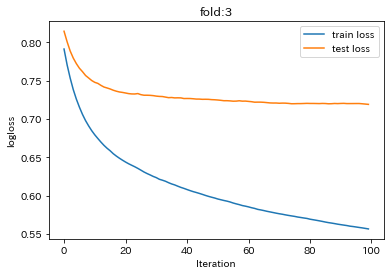

[I 2021-12-27 16:52:08,193] A new study created in memory with name: no-name-318edcdd-dd95-49a6-8a9c-459df17e1676
feature_fraction, val_score: 0.700735:  14%|######4                                      | 1/7 [00:00<00:00,  8.11it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000236 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.644933	Test's rmse: 0.700735
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


feature_fraction, val_score: 0.700735:  43%|###################2                         | 3/7 [00:00<00:00,  8.14it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.644933	Test's rmse: 0.700735
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000147 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	Train's rmse: 0.774376	Test's rmse: 0.772497
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000073 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Train

feature_fraction, val_score: 0.700735:  71%|################################1            | 5/7 [00:00<00:00,  8.11it/s]

Early stopping, best iteration is:
[35]	Train's rmse: 0.774376	Test's rmse: 0.772497
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	Train's rmse: 0.774376	Test's rmse: 0.772497
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until vali

feature_fraction, val_score: 0.700735: 100%|#############################################| 7/7 [00:00<00:00,  7.86it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.644933	Test's rmse: 0.700735
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[35]	Train's rmse: 0.774376	Test's rmse: 0.772497


num_leaves, val_score: 0.700735:   0%|                                                          | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.693705:   5%|##5                                               | 1/20 [00:00<00:05,  3.39it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.586858	Test's rmse: 0.693705
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000220 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.693514:  10%|#####                                             | 2/20 [00:00<00:06,  2.95it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.57897	Test's rmse: 0.693514
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.690576:  15%|#######5                                          | 3/20 [00:01<00:06,  2.74it/s]

Early stopping, best iteration is:
[45]	Train's rmse: 0.610396	Test's rmse: 0.690576
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.690576:  20%|##########                                        | 4/20 [00:01<00:07,  2.04it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.546691	Test's rmse: 0.694356
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.690576:  30%|###############                                   | 6/20 [00:02<00:04,  3.02it/s]

Early stopping, best iteration is:
[48]	Train's rmse: 0.608965	Test's rmse: 0.691394
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.669414	Test's rmse: 0.706338
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689645:  35%|#################5                                | 7/20 [00:02<00:05,  2.56it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.600069	Test's rmse: 0.689645
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689645:  40%|####################                              | 8/20 [00:03<00:05,  2.29it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.559145	Test's rmse: 0.694161
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000194 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689415:  45%|######################5                           | 9/20 [00:03<00:05,  2.19it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.60389	Test's rmse: 0.689415
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000248 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689415:  50%|########################5                        | 10/20 [00:04<00:04,  2.24it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.610263	Test's rmse: 0.692183
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689415:  55%|##########################9                      | 11/20 [00:04<00:04,  1.92it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.546691	Test's rmse: 0.694356
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689415:  60%|#############################4                   | 12/20 [00:05<00:04,  1.89it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.555758	Test's rmse: 0.697188
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000386 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689415:  65%|###############################8                 | 13/20 [00:05<00:03,  1.88it/s]

Early stopping, best iteration is:
[46]	Train's rmse: 0.599643	Test's rmse: 0.690948
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689415:  70%|##################################3              | 14/20 [00:06<00:02,  2.30it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.614705	Test's rmse: 0.696599
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000075 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689415:  75%|####################################7            | 15/20 [00:06<00:02,  2.10it/s]

Early stopping, best iteration is:
[43]	Train's rmse: 0.6019	Test's rmse: 0.68984
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689415:  80%|#######################################2         | 16/20 [00:07<00:01,  2.39it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.593399	Test's rmse: 0.695979
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689415:  85%|#########################################6       | 17/20 [00:07<00:01,  2.23it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.559975	Test's rmse: 0.69514
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689147:  90%|############################################1    | 18/20 [00:08<00:00,  2.04it/s]

Early stopping, best iteration is:
[49]	Train's rmse: 0.592348	Test's rmse: 0.689147
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000251 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689147:  95%|##############################################5  | 19/20 [00:08<00:00,  1.87it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.548489	Test's rmse: 0.693396
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


num_leaves, val_score: 0.689147: 100%|#################################################| 20/20 [00:09<00:00,  2.17it/s]


Early stopping, best iteration is:
[44]	Train's rmse: 0.610095	Test's rmse: 0.69316


bagging, val_score: 0.689147:   0%|                                                             | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.689147:  10%|#####3                                               | 1/10 [00:00<00:04,  1.93it/s]

Early stopping, best iteration is:
[36]	Train's rmse: 0.619165	Test's rmse: 0.690923
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.689147:  20%|##########6                                          | 2/10 [00:01<00:04,  1.72it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.571101	Test's rmse: 0.695412
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000229 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.689147:  30%|###############9                                     | 3/10 [00:01<00:04,  1.65it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.556026	Test's rmse: 0.69347
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

bagging, val_score: 0.689147:  40%|#####################2                               | 4/10 [00:02<00:03,  1.69it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000211 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -

bagging, val_score: 0.689147:  50%|##########################5                          | 5/10 [00:02<00:02,  1.75it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

bagging, val_score: 0.689147:  60%|###############################8                     | 6/10 [00:03<00:02,  1.73it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

bagging, val_score: 0.689147:  70%|#####################################                | 7/10 [00:04<00:01,  1.66it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.547005	Test's rmse: 0.694913
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.688106:  80%|##########################################4          | 8/10 [00:04<00:01,  1.62it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573001	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.688106:  90%|###############################################7     | 9/10 [00:05<00:00,  1.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.585223	Test's rmse: 0.696863
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


bagging, val_score: 0.688106: 100%|####################################################| 10/10 [00:06<00:00,  1.65it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.570752	Test's rmse: 0.691387


feature_fraction_stage2, val_score: 0.688106:   0%|                                              | 0/6 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000232 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.688106:  17%|######3                               | 1/6 [00:00<00:03,  1.59it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573001	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000214 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.688106:  33%|############6                         | 2/6 [00:01<00:02,  1.55it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573001	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.688106:  50%|###################                   | 3/6 [00:01<00:01,  1.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573001	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000219 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.688106:  67%|#########################3            | 4/6 [00:02<00:01,  1.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573001	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000215 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.688106:  83%|###############################6      | 5/6 [00:03<00:00,  1.54it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573001	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


feature_fraction_stage2, val_score: 0.688106: 100%|######################################| 6/6 [00:03<00:00,  1.62it/s]


Early stopping, best iteration is:
[22]	Train's rmse: 0.771841	Test's rmse: 0.775949


regularization_factors, val_score: 0.688106:   0%|                                              | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.688106:   5%|#9                                    | 1/20 [00:00<00:13,  1.43it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573001	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

regularization_factors, val_score: 0.688106:  10%|###8                                  | 2/20 [00:01<00:10,  1.65it/s]

Early stopping, best iteration is:
[37]	Train's rmse: 0.634555	Test's rmse: 0.688669
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.688106:  15%|#####7                                | 3/20 [00:01<00:10,  1.57it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573374	Test's rmse: 0.690616
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.688106:  20%|#######6                              | 4/20 [00:02<00:10,  1.54it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573001	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

regularization_factors, val_score: 0.688106:  25%|#########5                            | 5/20 [00:03<00:09,  1.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.578982	Test's rmse: 0.690933
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

regularization_factors, val_score: 0.688106:  30%|###########4                          | 6/20 [00:03<00:09,  1.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.574768	Test's rmse: 0.689102
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

regularization_factors, val_score: 0.688106:  35%|#############3                        | 7/20 [00:04<00:07,  1.74it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

regularization_factors, val_score: 0.688106:  40%|###############2                      | 8/20 [00:05<00:07,  1.60it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.572998	Test's rmse: 0.688377
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.688106:  45%|#################1                    | 9/20 [00:05<00:07,  1.55it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573001	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain,

regularization_factors, val_score: 0.688106:  50%|##################5                  | 10/20 [00:06<00:06,  1.55it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.594425	Test's rmse: 0.693132
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of

regularization_factors, val_score: 0.688106:  55%|####################3                | 11/20 [00:07<00:05,  1.53it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573001	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000156 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.688106:  60%|######################2              | 12/20 [00:07<00:05,  1.52it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573001	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.688106:  65%|########################             | 13/20 [00:08<00:04,  1.50it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573001	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.688106:  70%|#########################9           | 14/20 [00:09<00:04,  1.46it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573001	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.688106:  75%|###########################7         | 15/20 [00:09<00:03,  1.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573002	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000189 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.688106:  80%|#############################6       | 16/20 [00:10<00:02,  1.46it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573586	Test's rmse: 0.688395
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.688106:  85%|###############################4     | 17/20 [00:11<00:02,  1.46it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573002	Test's rmse: 0.688106
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687575:  90%|#################################3   | 18/20 [00:11<00:01,  1.46it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573734	Test's rmse: 0.687575
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


regularization_factors, val_score: 0.687575:  95%|###################################1 | 19/20 [00:12<00:00,  1.47it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573681	Test's rmse: 0.689669
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


regularization_factors, val_score: 0.687575: 100%|#####################################| 20/20 [00:13<00:00,  1.51it/s]


Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.573508	Test's rmse: 0.690261


min_data_in_leaf, val_score: 0.687575:   0%|                                                     | 0/5 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.687575:  20%|#########                                    | 1/5 [00:00<00:02,  1.45it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.514098	Test's rmse: 0.699535
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
Training until validation scores don't improve for 50 rounds


min_data_in_leaf, val_score: 0.687575:  40%|##################                           | 2/5 [00:01<00:01,  1.63it/s]

Early stopping, best iteration is:
[33]	Train's rmse: 0.544803	Test's rmse: 0.689535
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, be

min_data_in_leaf, val_score: 0.687575:  60%|###########################                  | 3/5 [00:01<00:01,  1.91it/s]

Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.646408	Test's rmse: 0.692846
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 510
[LightGBM] [Info] Number of data points in the train set: 10636, number of used features: 2
[LightGBM] [Info] Start training from score 0.372203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with pos

min_data_in_leaf, val_score: 0.687575:  80%|####################################         | 4/5 [00:01<00:00,  2.35it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

min_data_in_leaf, val_score: 0.687104: 100%|#############################################| 5/5 [00:02<00:00,  1.86it/s]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Did not meet early stopping. Best iteration is:
[100]	Train's rmse: 0.591733	Test's rmse: 0.687104


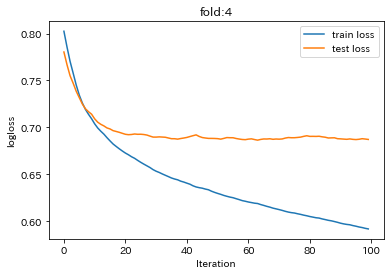

RMSE: [0.6878803766723421, 0.6932694859043071, 0.6776550765838206, 0.7187023250033101, 0.6871040473175472]
RMSE: 0.6929222622962655


In [15]:
y_train_dropna = y_train_dropna.reset_index(drop=True)

kf = KFold(n_splits=5)

groups = feature[:, 0]

params = {
          'task': 'train',              # タスクを訓練に設定
          'boosting_type': 'gbdt',      # GBDTを指定
          'objective': 'regression',    # 多クラス分類を指定
          'metric': 'rmse',  # 多クラス分類の損失（誤差）
          'learning_rate': 0.1,         # 学習率
          'seed': SEED                   # シード値
          }

best_params, history = {}, []

cv_result = []

for fold, (train_index, test_index) in enumerate(kf.split(feature, y_train_dropna, groups)):
    X_train_kf, X_test_kf = feature[train_index], feature[test_index]
    y_train_kf, y_test_kf = y_train_dropna.iloc[train_index], y_train_dropna.iloc[test_index]

    # 学習、推論
    lgb_train = lgb.Dataset(X_train_kf, y_train_kf)
    lgb_test = lgb.Dataset(X_test_kf, y_test_kf, reference=lgb_train)

    lgb_results = {}                                    # 学習の履歴を入れる入物

    model = lgb.train(
                    params,                    # ハイパーパラメータをセット
                    lgb_train,              # 訓練データを訓練用にセット
                    valid_sets=[lgb_train, lgb_test], # 訓練データとテストデータをセット
                    valid_names=['Train', 'Test'],    # データセットの名前をそれぞれ設定
                    num_boost_round=100,              # 計算回数
                    early_stopping_rounds=50,         # アーリーストッピング設定
                    evals_result=lgb_results,
                    verbose_eval=-1,                  # ログを最後の1つだけ表示
                    )  
    
    best_params = model.params

   # 損失推移を表示
    loss_train = lgb_results['Train']['rmse']
    loss_test = lgb_results['Test']['rmse']   
    
    fig = plt.figure()
    
    plt.xlabel('Iteration')
    plt.ylabel('logloss')

    plt.title(f"fold:{fold}")
    plt.plot(loss_train, label='train loss')
    plt.plot(loss_test, label='test loss')
    
    plt.legend()
    plt.show()

    # 推論
    y_pred = model.predict(X_test_kf, num_iteration=model.best_iteration)

    # 評価
    rmse = mean_squared_error(y_test_kf, y_pred, squared=False)
    cv_result.append(rmse)

print("RMSE:", cv_result)
print("RMSE:", np.mean(cv_result))

In [16]:
print("TSNE RMSE:", np.mean(cv_result))

TSNE RMSE: 0.6929222622962655
